# Imported Packages

Before I begin with my introduction I'll briefly cover the imported packages. I've compiled all imports below. Matplotlib, Numpy, Pandas, and Requests are required imports as part of the project guidelines. For this project I'm allowed to use up to five additional external packages - I used Seaborn, PIL, WordCloud, and NLTK.

```python
# Standard library imports
import json
import os
import re
from collections import Counter
from itertools import chain
from os import path

# Third-party imports
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns 
from PIL import Image
from wordcloud import WordCloud

# nltk imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# nltk downloads
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
```

In [1]:
from os import path
import json
from data_collection import load_or_download_books
from data_preprocessing import preprocess_all_books
from data_analysis import return_most_common, unique_words_from_texts, update_missing_words, calculate_tf_idf, calculate_word_pair_frequencies, analyze_ngrams
from data_graphing import create_wordcloud, create_barchart, create_mean_word_length_chart, generate_color_map, create_color_func, plot_tfidf_heatmap, plot_cooccurrence_heatmap, plot_ngrams

# Preface

Explanation of technologies/packages used, external source disclosure, assumptions, and conclusions can be found at the bottom of this document.

# Introduction and Data Collection

In this project I will analyze the word usage in five Sherlock Holmes novels. I've separated my scripts into different files (data_collection, data_preprocessing, data_analysis, and data_graphing) to improve organization. In this notebook I'll run the functions which I have in main.py and show what those functions are in the markdown text. In the code segments, I will run the defined functions as necessary (to process the text, graph it, etc.). To begin, I specify five Project Gutenberg urls which link to Sherlock Holmes novels. Project Gutenberg is a copyright-free respository of full novel texts. 

```python
urls = [
    "https://www.gutenberg.org/cache/epub/244/pg244.txt",    # A Study in Scarlet
    "https://www.gutenberg.org/cache/epub/3289/pg3289.txt",  # The Valley of Fear
    "https://www.gutenberg.org/cache/epub/2097/pg2097.txt",  # The Sign of the Four
    "https://www.gutenberg.org/cache/epub/2852/pg2852.txt",  # The Hound of the Baskervilles
    "https://www.gutenberg.org/cache/epub/1661/pg1661.txt",  # The Adventures of Sherlock Holmes
    ]
```

I use URL requests to download the text from the specified URLs, then use regex to extract metadata (Title, Author, Language; I don't use author or language, but include them for demonstrative purposes).

```python
# URL request; return plain text if successful 
def download_book(url):
    """
    Download the text from a given URL.
    Args: 
        url (string): Contains a Project Gutenberg URL.
    """
    response = requests.get(url)
    if response.status_code == 200:  # HTTP status code for OK
        return response.text
    else:
        print(f"Failed to download book from {url}")
        return None

# Get title, author, and language from the downloaded text
def extract_metadata(raw_text):
    """
    Extract metadata from the raw text.
    Args: 
        raw_text (string): Contains the unprocessed, downloaded text 
    """
    title_match = re.search(r"Title:\s*(.*?)\s*\n", raw_text)
    author_match = re.search(r"Author:\s*(.*?)\s*\n", raw_text)
    language_match = re.search(r"Language:\s*(.*?)\s*\n", raw_text)
    title = title_match.group(1) if title_match else "Unknown Title"
    author = author_match.group(1) if author_match else "Unknown Author"
    language = language_match.group(1) if language_match else "Unknown Language"
    return {"title": title, "author": author, "language": language}
```
With these functions, I save the full text (and metadata) to a JSON file (if the JSON file doesn't exist). If it does exist, I return the raw text JSON to be used later.  

```python
# Load raw books if available; if not, redownload them
def load_or_download_books():
    """
    If the book has not already been downloaded, download it, extract metadata, and save to a JSON file. If the book has been 
    downloaded, load the JSON file and open it.
    """
    try: 
        with open("books_raw.json", "r", encoding="utf-8") as f:
            rawbooks = json.load(f) 
            if not rawbooks:  # Check if the file is empty
                raise ValueError("The JSON file is empty.")
    except (FileNotFoundError, ValueError):
        # Download books to a JSON file if they haven't been downloaded
        print("Unable to load books_raw.json. Downloading books...")
        books = []
        for url in urls:
            raw_text = download_book(url)
            if raw_text:
                metadata = extract_metadata(raw_text)
                metadata["text"] = raw_text  # Include the full raw text
                books.append(metadata)
         # Save all books to the JSON file
        with open("books_raw.json", "w", encoding="utf-8") as f:
            json.dump(books, f, indent=4)
        # Reopen the file to read the saved data
        with open("books_raw.json", "r", encoding="utf-8") as f:
            rawbooks = json.load(f)            
    return rawbooks
```

In [2]:
# Load raw books, if available; if not, download them and save to books_raw.json
books = load_or_download_books()

# Data Preprocessing

Using regex and the NLTK package, I preprocess the text before I begin my analysis. I make it lowercase, remove the preamble and closing statements (from Project Gutenberg), remove digits, remove chapter numerals and some common words that NLTK doesn't account for, replace puncutation and dashes with spaces, remove multiple spaces, and remove trailing and leading spaces. Each of these actions is doable with a single line of code, so I kept all of this within one function. Finally, using NLTK, I tokenize the text and lemmatize it (which truncates words down to their base; for example, fires becomes fire). If a word is not contained in the NLTK stopword list, I add the word to my final list of filtered text. 

```python
def preprocess_text(text):
    """Convert raw text to preprocessed text.
        Args: 
            text (string): Contains the unprocessed, downloaded text 
    """
    # Make all text lower-case
    text = text.lower()
    # Remove the introductory Project Gutenberg text (before the book starts)
    text = re.sub(r"^.*?( \*\*\*)", "", text, flags=re.DOTALL)
    # Remove the end Project Gutenberg text (after the book ends)
    text = re.sub(r"(end of the project gutenberg.*)", "", text, flags=re.DOTALL)
    # Remove digits
    text = re.sub(r"\d+", "", text)
    # Remove Roman numerals (chapter numbers) and other words not handled correctly by NLTK
    text = re.sub(r"\b(ii|iii|iv|v|vi|vii|viii|ix|x|xi|xii|was|has|yes|said|us|would|could|upon|one|two|well|may)\b", "", text)
    # Replace punctuation with space 
    text = re.sub(r"[^\w\s]", " ", text) 
    # Replace dashes (hyphen, en dash, em dash) with spaces to preserve word separation
    text = re.sub(r"[\u2014\u2013\-_()]", " ", text)
    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)
    # Strip leading and trailing spaces
    text = text.strip()
    # Tokenize the text
    text = word_tokenize(text)
    # Lemmatize the text (rocks -> rock)
    lemmatized_text = []
    for w in text:
        lemmatized_text.append(WordNetLemmatizer().lemmatize(w))
    # Recreate the tokenized list but without NLTK stopwords
    filtered_text = []
    for w in lemmatized_text:
        if w not in stopwords.words('english'):
            filtered_text.append(w)
    return filtered_text
```
I load the book saved in the JSON file and use it in the function below to replace its raw text with a list of processed words.

```python
def preprocess_all_books(books_raw):
    """Convert raw text to preprocessed text.
        Args: 
            books_raw (json object): Contains all of the raw books - their text and metadata 
    """
    for book in books_raw:
        cleaned_text = preprocess_text(book["text"])  # Clean the raw text
        book["text"] = cleaned_text  # Replace the raw text with the cleaned version
```
Finally, I save this new processed text back to books_cleaned.json then open it and save it to a cleaned_books object to use in my analysis. It's easier to make a wordcloud with the wordcloud package using the processed text in a string format, so I'll make a dict with the title and text of each book and save to books_text and all_text (which contain a dict with the texts of the five books separated and a dict with the text of all books together, respectively).

In [3]:
# Preprocess each book (remove text, make lowercase, etc.) and update its text field
preprocess_all_books(books)

# Save the processed text back to a new JSON file
with open("books_cleaned.json", "w", encoding="utf-8") as file:
    json.dump(books, file, indent=4, ensure_ascii=False)  
    
# Read the processed text
with open("books_cleaned.json", "r", encoding="utf-8") as f:
    cleaned_books = json.load(f)

# Text from each book in string format to generate WordCloud
books_text = {book['title']: ' '.join(book['text']) for book in cleaned_books}

# Text from all novels in string format to generate WordCloud
all_text = {
    "Sherlock Holmes Novels": ' '.join(books_text.values()),
}


# WordCloud of 10 Most Common Words in Each Novel

In the code below, I create a dict with a list of the book titles and their most common words using the return_most_common function (shown below), which functions simply by using the Counter library from collections.

```python
def return_most_common(text, number_common_words):
    '''
    Returns the top [number_common_words] most common words for a text.
    Args:
        text (string): The full text of the novel to be analyzed 
        number_common_words (int): What number of most common words to return 
    '''
    word_counts = Counter(text.split())
    most_common = word_counts.most_common(number_common_words)
    return most_common
```

Next, I want each word to have a color assigned to it. This will keep my graphics consistent; these words will appear in various wordclouds, barcharts, etc. so this is important for making the visual analysis easier. To do this, I take the common words which I've just generated and put them into a color function (a requirement of the WordCloud library I used) and then put this function into a color mapping function (which was used with barcharts). The color function is based on the color mapping, so colors will stay consistent. The code for the color function and color mapping is shown below.

```python
def generate_color_map(common_words):
    """
    Generate a color map dictionary based on the given common words.
    Args:
        common_words (dict): A dictionary with top N common words listed beside their count, for each text.
    """
    return {word: cm.tab20b(i % 20) for i, word in enumerate(sorted(common_words))}

def create_color_func(color_map):
    """
    Create a color function (and convert to RGB values) for the WordCloud library.
    Args:
        color_map (dict): A dictionary of words with predefined colors
    """
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        # Convert the color from float format to integer format (0-255)
        color = color_map.get(word, (0, 0, 0))  # Default to black if word is not in color_map
        return tuple(int(c * 255) for c in color[:3])  # Convert to RGB
    return color_func
```
In generate_color_map function I sort the list of common words and enumerate it (assign a number for each entry). Then I use this number to assign a color from Matplotlib's colormapping. If there are more than 20 words in the common_words dict then it will wrap around. WordCloud needs a special color_function; to create this I'll first feed in the color_map, then I need to return a color_function to use in the WordCloud. WordCloud also needs RGB values. I default words to black if they aren't in the color mapping and return the color_function for use in the WordCloud. Finally I take the floating point values of colors (between 0 and 1) and multiply by 255 to return an RGB value.

Next we'll look at the code needed to generate a WordCloud. I used the external WordCloud library for this.

```python
def create_wordcloud(books_text, color_function, unique_chart=False):
    """
    Generate and plot a wordcloud for most common words.
    Args:
        books_text (dict): A dictionary of books with processed text.
        color_function (function): Passes colors assigned to most common words.
        unique_chart (bool): True only if it a unique wordchart (as opposed to a most common wordchart) is desired.
    """
    #Create mask in the shape of a magnifying glass
    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
    mask_image = np.array(Image.open(path.join(d, "magnifier.png")))
    mask_image[mask_image == 0] = 255
    # Create subplots for word clouds
    fig, axes = plt.subplots(1, len(books_text), figsize=(20, 8))
    # If there is only one subplot, axes will not be a list; convert to list
    if len(books_text) == 1:
        axes = [axes]
    # Generate word clouds for each book and display
    for ax, (title, text) in zip(axes, books_text.items()):
        wc = WordCloud(
            background_color="white",
            mask=mask_image,
            width=1200,
            height=750,
            color_func=color_function  # Apply consistent color function
        ).generate(text)
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off") 
        ax.set_title(title, fontsize=16, pad=10, loc='center') 
    # Adjust layout and display
    if (len(books_text) != 1):
        plt.suptitle(
        "Unique Words" if unique_chart else "Most Common Words",
        fontsize=18, y = 0.8  
        )
    else:
        plt.suptitle(
        "Unique Words" if unique_chart else "Most Common Words",
        fontsize=18, y = 1 
        )
    plt.tight_layout()
    plt.show()
```
This takes in the full text of a book and takes the most common words automatically, representing them as larger if they are more frequent. It also takes in the color_function we created, which will keep colors consistent and highlight our most common words while keeping words that aren't in the top 10 most common words as black. There is also an optional unique field, which we'll look at later.

I wanted my WordCloud to be in the form of a magnifying glass, since Sherlock Holmes is a detective. I downloaded a .png of a magnifying glass (black and white) and converted it to an array with Numpy. Then I assign any empty parts of the array to white.

The rest of the code is straightforward plotting using matplotlib.pyplot and the default options in the WordCloud library. 



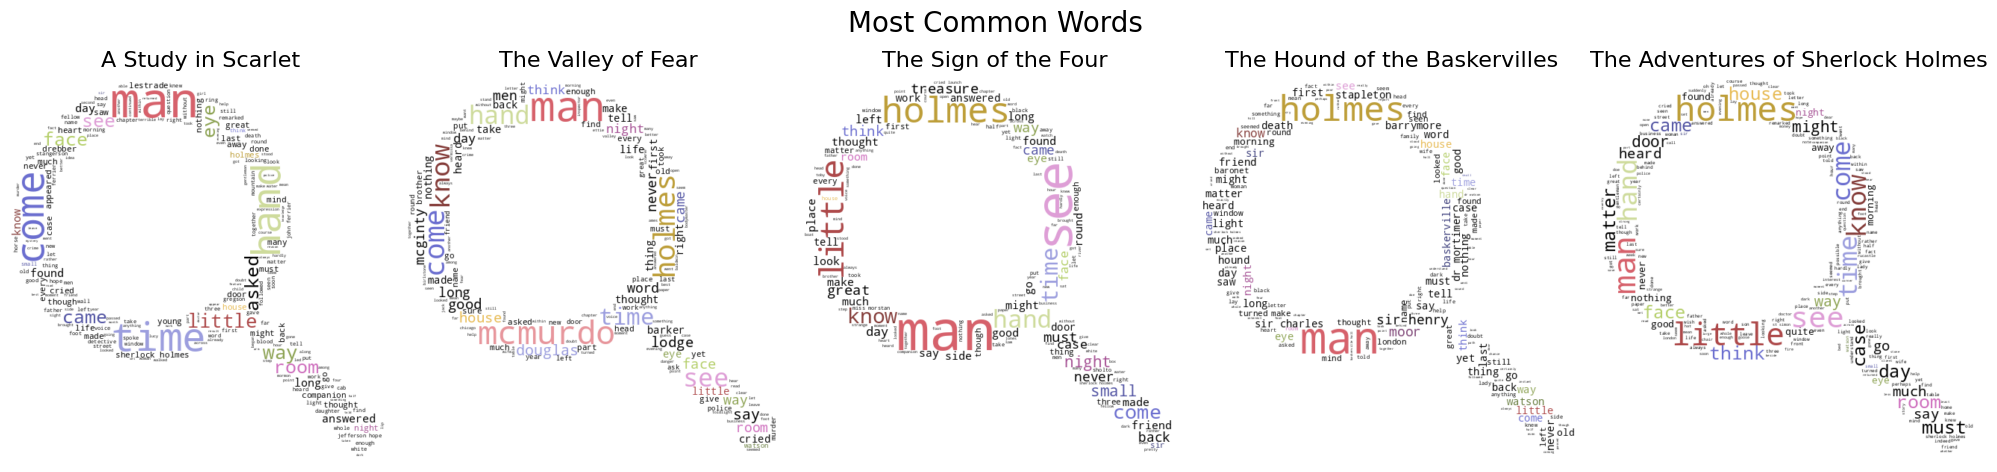

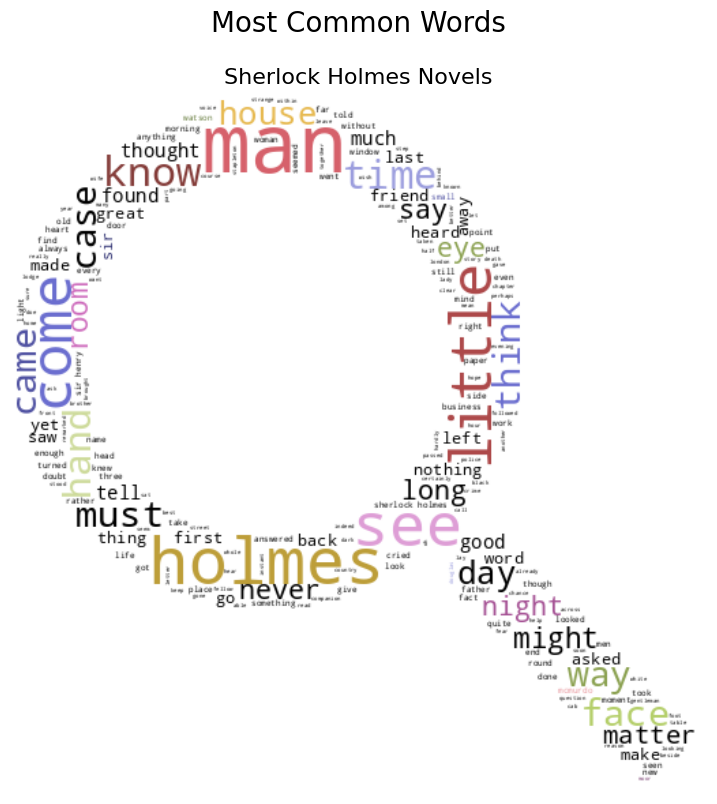

In [4]:
# 10 most common words for each book
books_common_words = {title: return_most_common(text, 10) for title, text in books_text.items()}

# 10 most common words for all of the novels
all_text_common_words  = {
    "Sherlock Holmes Novels": return_most_common(all_text["Sherlock Holmes Novels"], 10),
}

# Take the most common words and assign a color to them which is consistent for graphical analysis. Wordclouds use a color function, barcharts use a color mapping
common_words = set(word for book in books_common_words.values() for word, _ in book)
color_map = generate_color_map(common_words)
color_func = create_color_func(color_map)

# Create 5 wordclouds for each of the novels showing most common words
create_wordcloud(books_text, color_func)

# Create a wordcloud which shows the most common words for all novels
create_wordcloud(all_text, color_func)


We have six wordclouds above in the shape of magnifying glasses (for the Sherlock Holmes theme). The first 5 wordclouds show the most common words for each of the novels in our corpus alongside their titles. The 6th wordcloud shows the most common words for all of the novels combined. We can already see some patterns of common words, like "man" and "holmes". In our next section we'll represent these most common words in a barchart showing counts for each. 

# Barcharts for Counts of 10 Most Common Words in Each Novel

Using the color_map created above (so the colors stay consistent between the WordCloud and the barcharts), we'll now defined a create_barchart function to plot the relative counts and frequencies of the most common words. 

```python
def create_barchart(books_common_words, color_map, normalize=False, books_text=None):
    """
    Generate and plot barcharts for word counts or frequencies.
    Args:
        books_common_words (dict): A dictionary of books with their most common words and counts.
        color_map (dict): A mapping of words to colors for consistent visual representation.
        normalize (bool): Set to true to normalize word counts based on the total word count of the book. False by default.
        books_text (dict): A dictionary of books with their full text (needed for normalization).
    """
    # Calculate normalized frequencies if required
    if normalize and books_text:
        normalized_common_words = {}
        for title, words in books_common_words.items():
            total_words = len(books_text[title].split())
            normalized_common_words[title] = [(word, count / total_words) for word, count in words]
        books_common_words = normalized_common_words
    # Plot most common words
    fig, axes = plt.subplots(nrows=1, ncols=len(books_common_words), figsize=(18, 6), sharey=True)
    # If there is only one subplot, axes will not be a list; convert to list
    if len(books_common_words) == 1:
        axes = [axes] 
    for ax, (book, words) in zip(axes, books_common_words.items()):
        words, counts = zip(*words)  
        # Assign colors based on the consistent color mapping
        colors = [color_map[word] for word in words]
        bars = ax.bar(range(len(words)), counts, color=colors)   
        ax.set_title(book, fontsize=12)
        ax.set_xticks(range(len(words)))
        ax.set_xticklabels(words, rotation=45, ha="center", fontsize=8)
        ax.set_xlabel("Words", fontsize=12)
        ax.set_ylabel("Frequency" if normalize else "Count", fontsize=12)
        ax.grid(axis="y", linestyle="--", alpha=0.7)     
        # Annotate bars with count values
        if not normalize:
            for bar, count in zip(ax.patches, counts):
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, str(count), ha='center', va='bottom', fontsize=7
            )
    fig.suptitle(
        "Top 10 Most Common Words (Normalized by Total Words)" if normalize else "Top 10 Most Common Words",
        fontsize=16
    )
    fig.tight_layout()
    plt.show()
```

Most of this is typical - except I've also added an option to make a normalized barchart. To make this, I can set the normalize argument to true and also input the book texts. Then, the function will divide the number of word counts by the total number of words in the text. This way we can plot frequencies instead of counts - since the novels are all different lengths, normalizing to frequencies could enhance our analysis. Now that I have a function, I'll plot the barcharts.

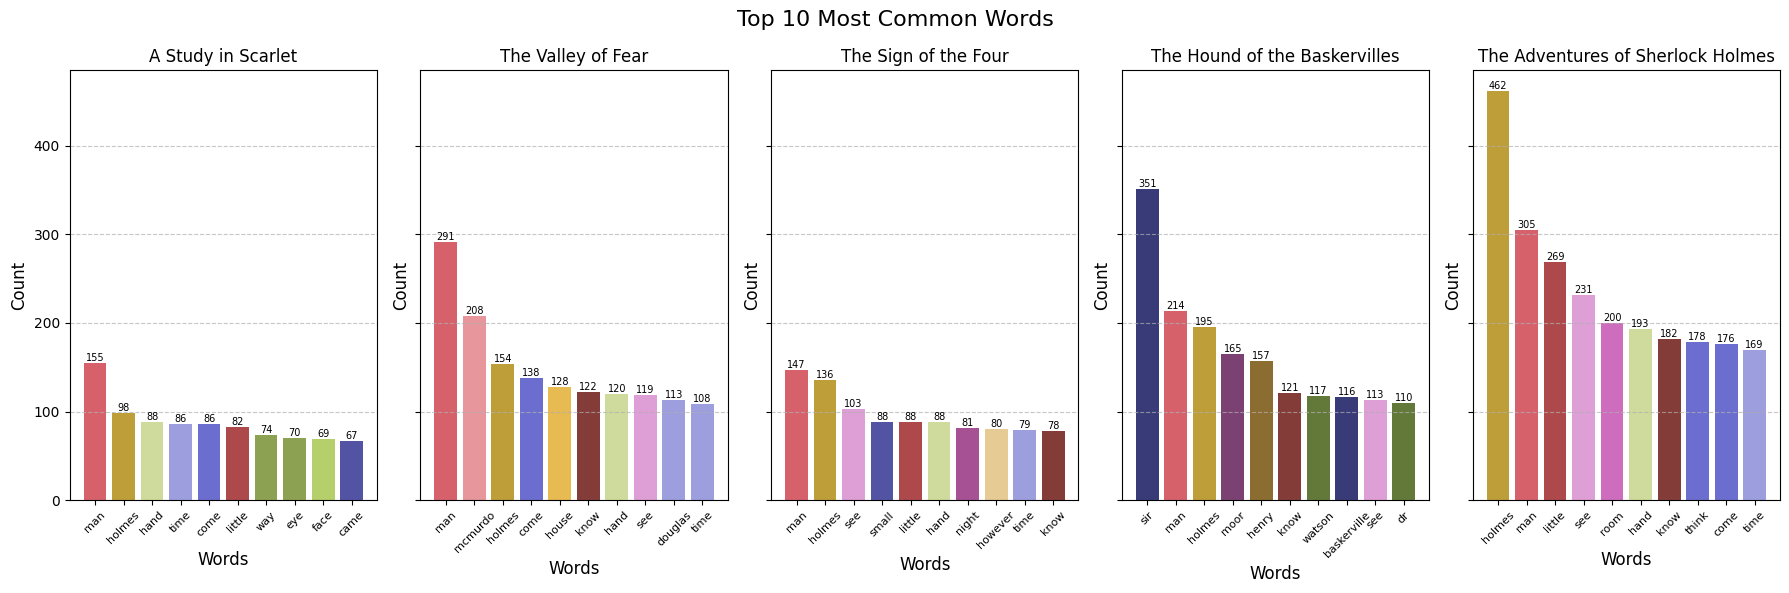

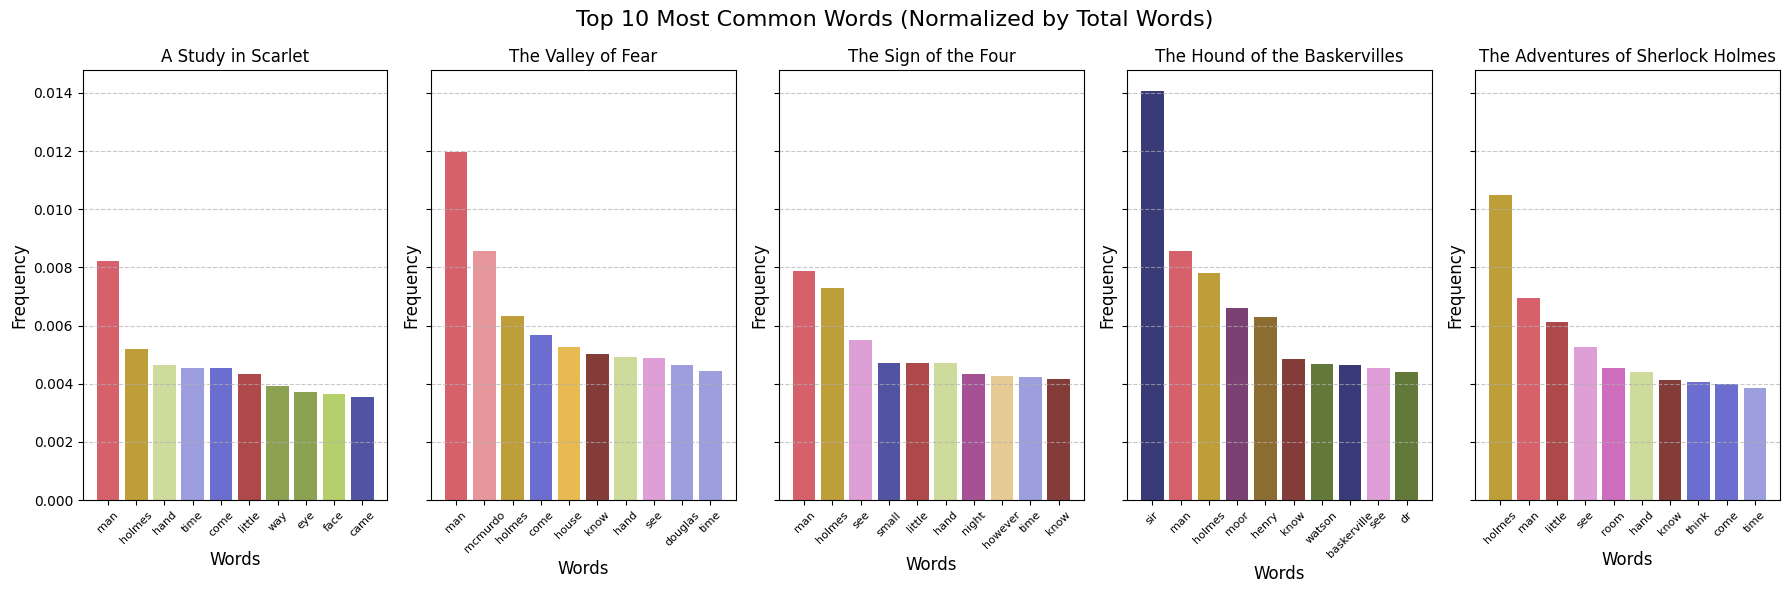

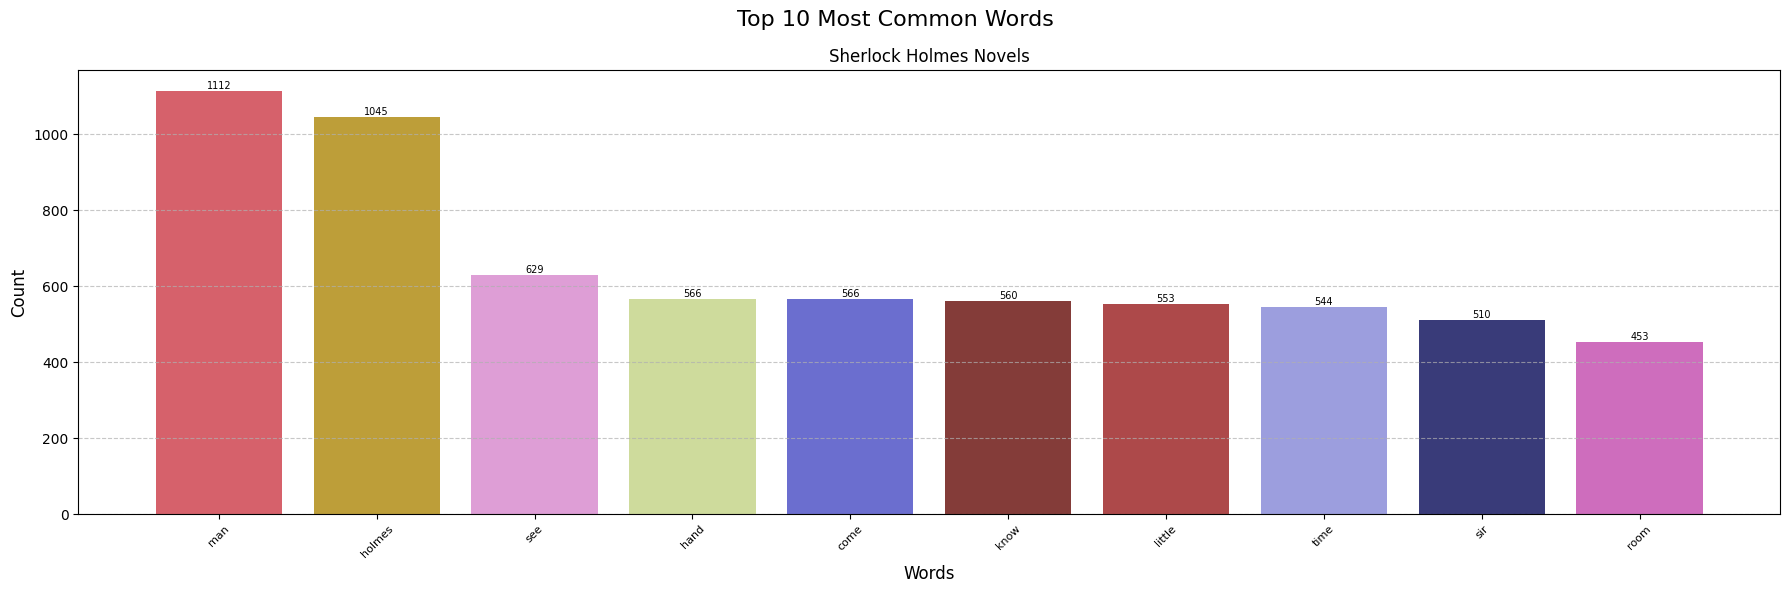

In [5]:
 # Create 5 barcharts to compare counts of most common words
create_barchart(books_common_words, color_map)

# Create 5 barcharts to compare frequencies of most common words
create_barchart(books_common_words, color_map, True, books_text)

# Create a barchart which shows the most common words for all novels
create_barchart(all_text_common_words, color_map)

I've plotted the top 10 most common words counts for each novel, the top 10 most common words by frequency of usage (normalized by total word count), and the overall top 10 most common words in all of the novels. "Man" is the overall most common word, followed by "Holmes" and "see". But on a per-novel basis, there are different most common words - like "sir" in The Hound of the Baskervilles. If we normalize counts by total number of words in each novel, "sir" becomes by far the most frequently used word in The Hound of the Baskervilles, but overall it is not as common in the other texts. Some of the most common words we see, like "McMurdo" or" Watson" are character names, while others could relate to the description of a scene ("room", "hand", "face").

# Mean Word Length of the 50 Most Common Words in Each Sherlock Holmes Novel

How long are the 50 most common words in each novel? Is there a trend over time? To investigate this, I created a calculate_mean_word_length function below. I input the dictionary with each novel and its text and also specifiy the number of most common words I want to calculate. Then I use my return_most_common function from before and retrieve the specified N most common words. Finally I calculate a mean for these most common words and return them. 

```python
def calculate_mean_word_length(text_dict, number_common_words):
    '''
    Calculate the mean length of the most common words for each book.
    Args:
        text (dict): A dictionary where keys are book titles and 
        values are full texts
        number_common_words (int): The number of most common words to calculate average length of 
    '''
    common_words_dict = {title: return_most_common(text, number_common_words) 
                        for title, text in text_dict.items()}
    mean_lengths = {}
    for book, words in common_words_dict.items():
        # Extract the words and calculate their lengths
        word_lengths = np.array([len(word) for word, _ in words])
        # Compute the mean length
        mean_lengths[book] = round(float(np.mean(word_lengths)), 2)
    return mean_lengths
```

Using the output from the function above, I can create a line chart which shows the mean word length for the top 50 words of each novel. I set up this line chart function below. 

```python
def create_mean_word_length_chart(text_dict, number_common_words):
    '''
    Create a line chart for the mean word lengths of the most common words in books.
    Args:
        text_dict (dict): A dictionary where keys are book titles and values are texts
        number_common_words (int): The number of most common words to calculate average length of 
    '''
    mean_lengths = calculate_mean_word_length(text_dict, number_common_words)
    # Convert to DataFrame
    df = pd.DataFrame(list(mean_lengths.items()), columns=['Book', 'Mean Word Length'])
    df['Index'] = np.arange(len(df))
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df['Index'], df['Mean Word Length'], marker='o', color='black', label='Mean Word Length')
    plt.xticks(df['Index'], df['Book'], rotation=30, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    for x, y in zip(df['Index'], df['Mean Word Length']):
        plt.text(x + 0.14, y - 0.019, f'{y:.2f}', ha='center', fontsize=10, color='blue')
    plt.title(f'Mean Word Length of the {number_common_words} Most Common Words in Sherlock Holmes Novels', fontsize=16)
    plt.xlabel('Books', fontsize=12)
    plt.ylabel('Mean Word Length', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Display
    plt.tight_layout()
    plt.show()
```

I use a pandas dataframe alongside my calculate_mean_word_length function to list each book alongside the mean word length, then use regular plotting code to create a line chart. 

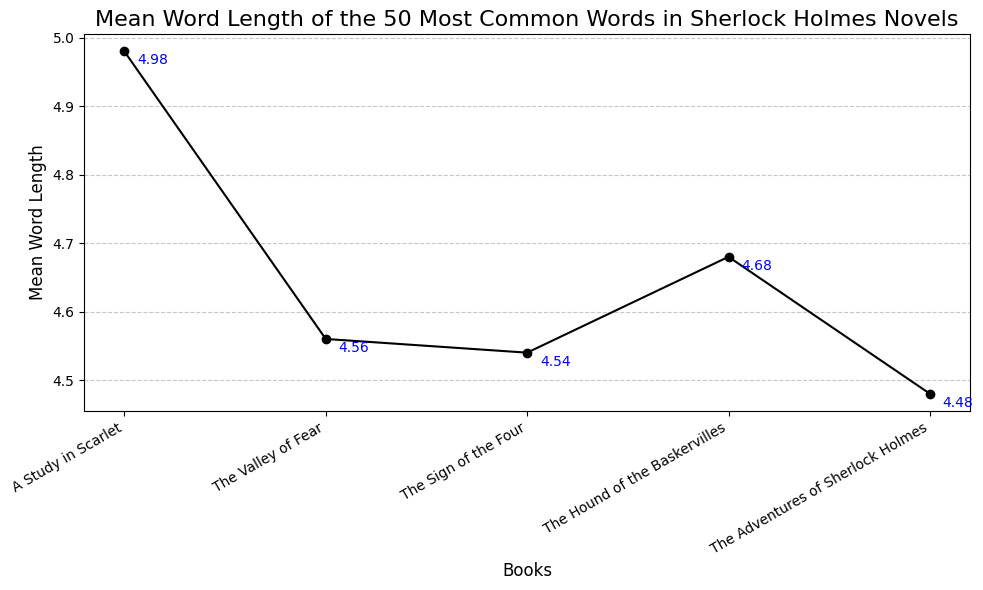

In [6]:
# Create a line chart which shows the average length of the top n (in this case, 50) words for each novel
create_mean_word_length_chart(books_text, 50)

The average length of the top 50 words in each novel goes down drastically after the first novel, then remains relatively constant. Maybe after his first novel, the author got tired of writing such long words? Or maybe there is little analytical value to this metric - after all, the average length of the top 50 words in A Study in Scarlet is only half a letter longer than the average length length of the top 50 words in The Adventures of Sherlock Holmes. 

# WordCloud of Unique Words in Each Novel

Rather than the most common words in each novel, what about words that appear only in one novel and in none of the others? To figure this out, I create a unique_words_from_texts function which takes in the full texts. I extract the words from the full text and store in a word_sets dict. I start of working with a single set from one book. Using itertools chain function, I combine the set of words in all the other books. I then create a set to get rid of duplicate words, and I compare each word to make sure it doesn't match another word in the set. I iterate over all the books to finally produce all the unique words in a title : unique_word_set dictionary. 

```python
def unique_words_from_texts(book_texts):
    '''
    Identify unique words for each book based on their presence across all texts.
    Return a dictionary with book titles as keys and unique words for each book, including duplicates, as the value. 
    Args:
        book_texts (dict): Dictionary with book titles as keys and full text as values.
    '''
    # Tokenize each book into a list of words
    tokenized_texts = {
        title: re.findall(r'\b\w+\b', text)
        for title, text in book_texts.items()
    }
    # Create sets of words for each book to determine uniqueness
    word_sets = {
        title: set(words) for title, words in tokenized_texts.items()
    }
    # Identify unique words for each book
    unique_words = {
        book: [
            word for word in tokenized_texts[book]
            if word not in set(chain(*[word_sets[b] for b in word_sets if b != book]))
        ]
        for book in tokenized_texts
    }
    return unique_words
```
By joining all these unique words together, I can produce a WordCloud (with my same WordCloud function) of all the words which are unique to each novel (don't appear in any of the other four novels).

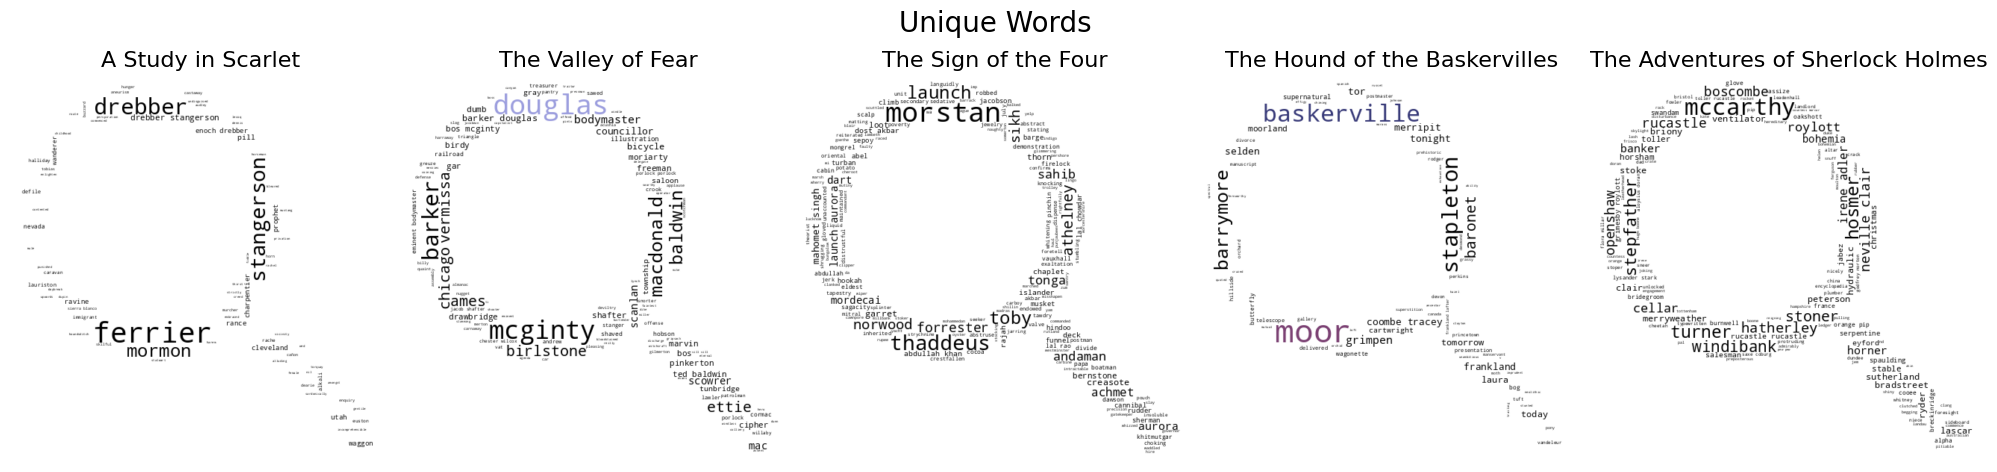

In [7]:
# Create 5 wordclouds for each of the novels, showing unique words in each
create_wordcloud({title: ' '.join(words) for title, words in unique_words_from_texts(books_text).items()}, color_func, True)

Each WordCloud shows completely unique words for each of the novels. Why are most of our words black? Because they aren't a part of the overall most common words. Some are - "Douglas", "Baskerville", and "moor" are in the most common overall words, AND they're unique to The Valley of Fear and The Hound of the Baskervilles, respectively. As expected, most of these unique words are proper names. But a few of them aren't, such as "mormon" (a Christian-adjacent religion), or "moor" (an archaic British word for an uncultivated upland). These unique words that aren't proper names tell us more about the interesting parts of the novel settings.

# TF-IDF Calculation and Heatmap

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (corpus). It balances two factors - Term Frequency (TF), which measures how often a word appears in a document, and Inverse Document Frequency (IDF) which downscales words that appear frequently across many documents, making them less important. Multipying TF and IDF give us TF-IDF.

First I'll update our list of common words. Right now it only calculates the top N words for each book. But I want it to do that, and also calculate the frequency of those terms in all of the books. 

```python
def update_missing_words(common_words, books_text):
    '''
    Complete the most common word dictionary by appending the most common words from one novel (ie "hand" in Study in Scarlet) to another (ie Hound of Baskerville) with count (the count of "hand" in Hound of Baskerville)
    Args:
        word_frequencies (dict): Dictionary with book titles as keys and list of tuples (word, frequency) as values.
        books_text (dict): A dictionary of books with their full text.
    '''
    # Create a set of all the most common words across all books
    all_common_words = set(word for words in common_words.values() for word, _ in words)
    # Dictionary to store the updated common words with frequencies
    updated_books_common_words = {}
    # Iterate over each book's common words
    for title, top_words in common_words.items():
        # Get the set of words already in the top 10 for the current book
        current_top_words = set(word for word, _ in top_words)
        # Prepare a Counter for the full word frequencies in this book that haven't been calculated
        full_word_freq = Counter(re.findall(r'\b\w+\b', books_text[title].lower()))
        # List to hold updated words for this book
        updated_top_words = top_words[:]
        # Check for missing common words and calculate their frequency if needed
        for word in all_common_words:
            if word not in current_top_words:
                # Calculate the frequency of the word in the book and append it
                updated_top_words.append((word, full_word_freq[word]))
        # Store the updated common words for the book
        updated_books_common_words[title] = updated_top_words
    return updated_books_common_words
```

Now that I have a dict of word frequencies which is comprehensive (for example, even though "moor" is not in The Valley of Fear top 10 words I now have its count in this novel), I'll calculate the TF-IDF. I create a Panda dataframe with the book, the word, its count, and the TF. TF is calculated by dividing the number of word occurrences by the total number of words. Next I calculate the IDF, which is done by dividing the total number of texts in the corpus by the number of texts which contain that word and then taking the logarithm. That is the standard way to calculate IDF - there is also a "smooth IDF" calculation which is done by adding 1 to the denominator as well as after the logarithm is calculated. My function will optionally allow me to calculate this. TD-IDF is calculated by multiplying TF and IDF. I add my calculations to the Panda dataframe and return it - it has columns for the book title, the word, the frequency (count), TF, IDF, and TF-IDF.

```python
def calculate_tf_idf(word_frequencies, books_text, smooth=False):
    '''
    Calculate TF-IDF scores for common words across books.
    Args:
        word_frequencies (dict): Dictionary with book titles as keys and list of tuples (word, frequency) as values.
        books_text (dict): A dictionary of books with their full text.
        smooth (bool): Optionally compute smooth IDF.
    '''
    # Total number of documents
    num_texts = len(word_frequencies)
    # Convert frequencies to DataFrame
    data = []
    for book, freqs in word_frequencies.items():
        for word, freq in freqs:
            total_words = len(books_text[book].split())
            data.append([book, word, freq, freq / total_words])
    tf_df = pd.DataFrame(data, columns=['Book', 'Word', 'Frequency', 'TF'])
    # Calculate IDF
    all_words = set(tf_df['Word'])
    #Create a set of all unique words
    all_words = set(word for book in word_frequencies.values() for word, _ in book)
    #Count how many books contain each word
    num_books = len(word_frequencies)
    word_doc_count = {
        word: sum(1 for freqs in word_frequencies.values() if any(w == word and count > 0 for w, count in freqs))
        for word in all_words
    }
    #Calculate IDF for each word
    idf_scores = {}
    for word in all_words:
        # Check if the word appears in any documents (books)
        doc_count = word_doc_count[word]
        # Apply "smooth" IDF formula if option enabled
        if smooth:
            idf_scores[word] = np.log(1 + (num_books / (doc_count + 1)))
        else:
            idf_scores[word] = np.log((num_books / (doc_count)))
    # Calculate TF-IDF
    tf_df['IDF'] = tf_df['Word'].map(idf_scores)
    tf_df['TF-IDF'] = tf_df['TF'] * tf_df['IDF']
    return tf_df
```
With my Panda dataframe, I'll display the data using a heatmap (requires importing the seaborn library). This is relatively straightforward. I can change the title using my optional smooth boolean, and I multiply my TF-IDF values by 1000 for ease of viewing.

```python
def plot_tfidf_heatmap(tfidf_df, smooth=False, top_n=26):
    """
    Plot a heatmap of TF-IDF scores for the top N words per book.
    Args:
        tfidf_df (pd.DataFrame): The DataFrame containing TF/IDF/TF-IDF data.
        smooth (bool): Optionally graph smooth IDF.
        top_n (int): Number of top words per book to include.
    """
    # Filter top N words per book
    top_words = (
        tfidf_df.groupby("Book")
        .apply(lambda x: x.nlargest(top_n, "TF-IDF"))
        .reset_index(drop=True)
    )
    # Pivot table to create a matrix for heatmap
    heatmap_data = top_words.pivot_table(
        index="Word", columns="Book", values="TF-IDF", fill_value=0
    ) * 1e3
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data,
        cmap="YlGnBu",
        annot=True,
        fmt=".2f",
        cbar_kws={"label": "TF-IDF Score"},
        linecolor='black',  
        linewidths=1
    ) 
    if smooth:
        plt.title("Heatmap of Common Words by TF-IDF Scores (Using Smooth IDF calculation) (scaled by 1e3)", fontsize=16)
    else:
        plt.title("Heatmap of Common Words by TF-IDF Scores (scaled by 1e3)", fontsize=16)
    plt.ylabel("Words")
    plt.xlabel("Books")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
```

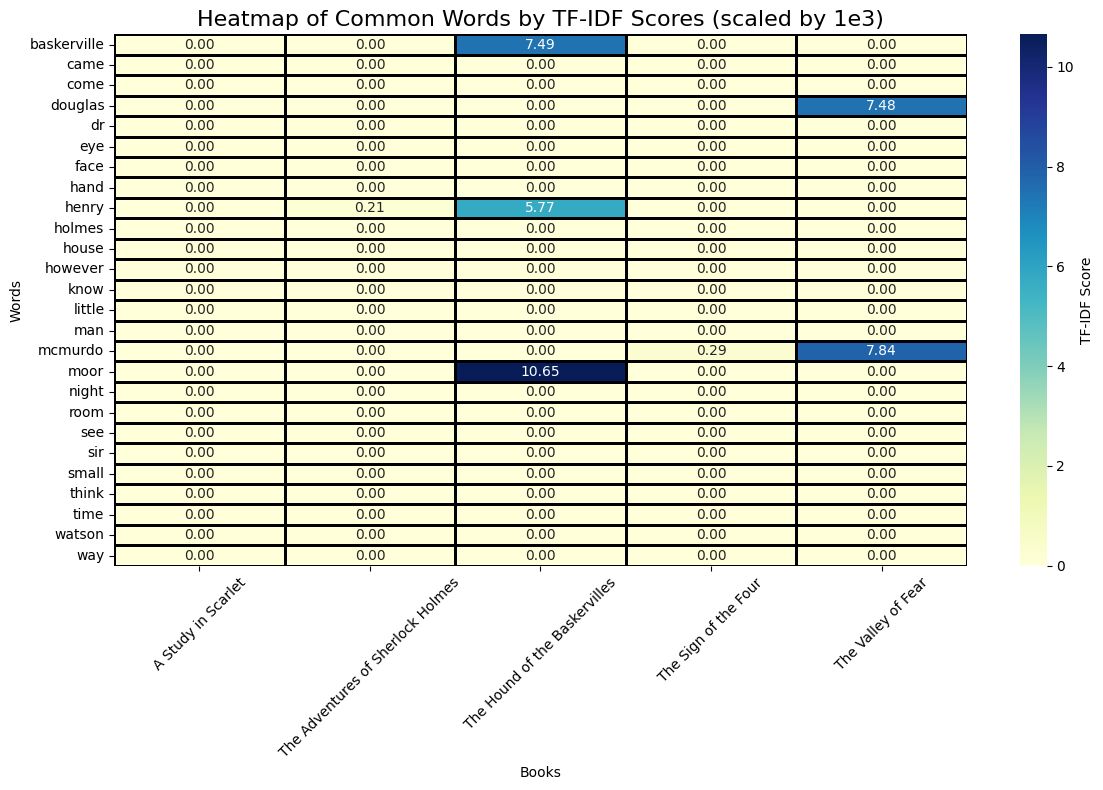

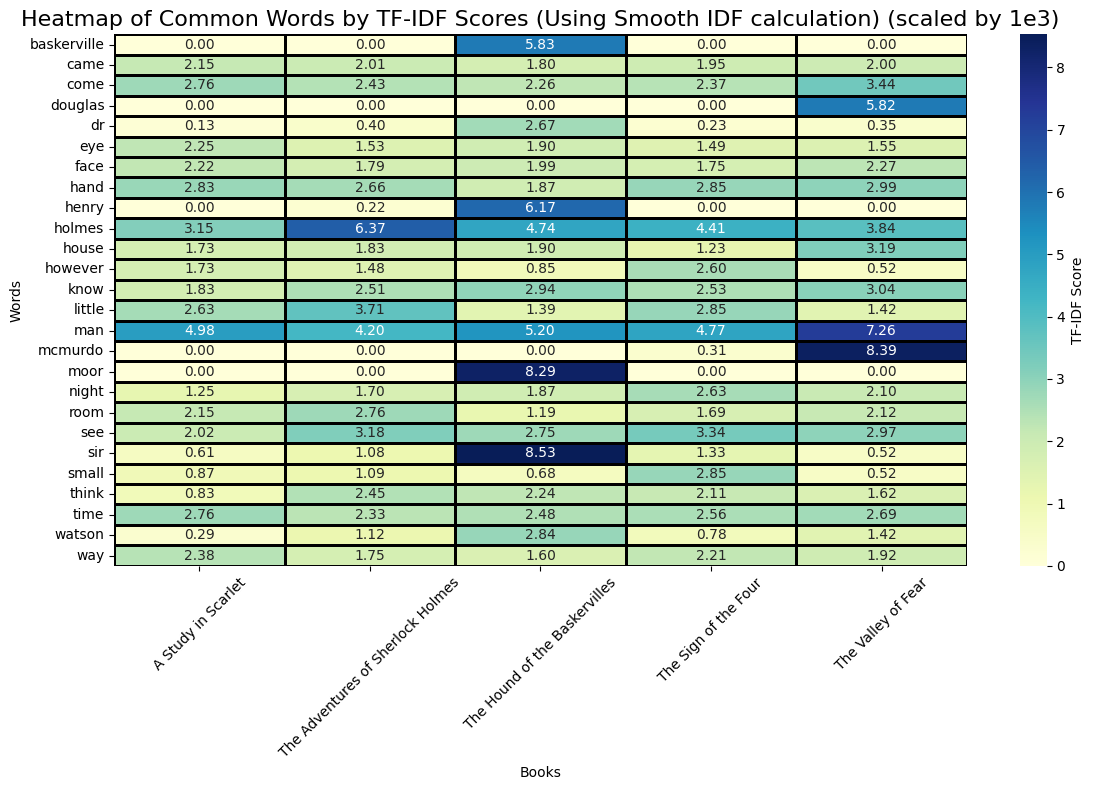

In [8]:
#Plot standard tfidf heatmap
plot_tfidf_heatmap(calculate_tf_idf(update_missing_words(books_common_words, books_text), books_text))

#Plot smooth tfidf heatmap
plot_tfidf_heatmap(calculate_tf_idf(update_missing_words(books_common_words, books_text), books_text, smooth=True), smooth=True)

Because I'm looking at the top 10 most common words for each book (26 words in total, since there are some most common words that are shared), many of them appear across books. In calculating IDF - log( [total books] / [books the word appears in]) - if a word is in all of the books, then the IDF will be 0. That means the TF-IDF will also be 0. There are still some words that pass through this filter - moor, Henry, and Baskerville, if seen, tell you that you're reading Hound of the Baskervilles. McMurdo and Douglas, if read, tell you that you're reading Valley of Fear.

In order to look at what's going on more closely, in my second heatmap I calculated TF-IDF using a "smooth" IDF calculation in which look like 1 + log( [total books] / [1 + books the word appears in]). This allows us to see some other trends. For example, even though "sir" appears in every book, you're far more likely to see it in Hound of the Baskervilles. "Dr." is also in all of the books, but again is far more prevalent in Hound of the Baskervilles. In general, the numbers in these heatmaps tell us about how important (TF) and unique (IDF) the word is for each novel and among the entire corpus.

# Co-occurrence heatmap for the 50 most common words

Now I'd like to see which of the 50 most common words appear frequently together. For example, "starry night" is a common English phrase. We're more likely to see the words "starry" and "night" next to each other than we are to see "green" and "night" next to each other. I will count the number of times words are co-located in a 3-word segment and display the count in a heatmap.

In my calculate_word_pair_frequencies function, I take all of the text, a common word list, and a window size (window size of 1 means looking at one word to the left and one word to the right of a target word). I identify the indices of evey instance of a common word in the text, then I iterate through the text to look at every triplet of words. If the triplet contains two of the common words, I add it to a count in the co-occurrence matrix. I then increase the index so I won't double-count these words. I return the co-occurrence matrix in the form of a dictionary for each book, although in my analysis the "book" I'll be using is the entire corpus. The function is set up to do this analysis for any one individual book, if desired.

```python
def calculate_word_pair_frequencies(all_text, common_word_list, window_size):
    """
    Calculate co-occurrence frequencies of common words within a window size in the given texts.
    Args:
        all_text (dict): Dictionary with title as key and corresponding full texts as value.
        common_word_list (dict): Dictionary with title as key and lists of common words as values.
        window_size (int): The size of the window to check for word co-occurrences.
    Returns:
        dict: Co-occurrence matrices for each text identifier.
    """
    cooccurrence_matrices = {}
    for book, text in all_text.items():
        # List of common words for the current book
        common_words = common_word_list[book]
        word_indices = [i for i, word in enumerate(text.split()) if word in common_words]
        # Initialize the co-occurrence matrix
        matrix = np.zeros((len(common_words), len(common_words)), dtype=int)
        word_to_index = {word: i for i, word in enumerate(common_words)}
        # Set to track already counted indices
        counted_indices = set()
        # Iterate through words and count co-occurrences
        words = text.split()
        idx = 0  # Pointer to the current word index
        while idx < len(word_indices):
            word_idx = word_indices[idx]
            if word_idx in counted_indices:
                idx += 1
                continue  # Skip if the word index has already been counted
            window_start = max(word_idx - window_size, 0)
            window_end = min(word_idx + window_size + 1, len(words))
            window_words_indices = [
                (i, words[i]) for i in range(window_start, window_end) if i not in counted_indices
            ]
            for i, (index1, word1) in enumerate(window_words_indices):
                for j, (index2, word2) in enumerate(window_words_indices[i + 1 :], start=i + 1):
                    if (
                        #word1 != word2
                        word1 in word_to_index
                        and word2 in word_to_index
                    ):
                        # Count the co-occurrence of the pair
                        matrix[word_to_index[word1], word_to_index[word2]] += 1
                        matrix[word_to_index[word2], word_to_index[word1]] += 1  # Symmetric
                        counted_indices.add(index1)
                        counted_indices.add(index2)
            # Increment the index to skip the word after counting
            counted_indices.add(word_idx)
            idx += 1
        cooccurrence_matrices[book] = matrix
    return cooccurrence_matrices
```
Now that I have a symmetric matrix which contains counts of co-occurrence for pairs of words, I make a function to graph a heatmap of this using Seaborn again. This is straightforward.

```python
def plot_cooccurrence_heatmap(cooccurrence_matrices, common_word_list, window_size):
    """
    Plot a heatmap of the co-occurrence frequencies for each book.
    Args:
        cooccurrence_matrices (dict): Dictionary where keys are book titles and values are co-occurrence matrices.
        common_word_list (dict): Dictionary where keys are book titles and values are lists of common words.
        window_size (int): The size of the window to check for word co-occurrences.
    """
    for book, matrix in cooccurrence_matrices.items():
        words = common_word_list[book]  # Get the corresponding common words for the current book
        # Set up the figure
        plt.figure(figsize=(10, 8))
        
        # Create the heatmap
        heatmap = sns.heatmap(
            np.log1p(matrix),
            xticklabels=words,
            yticklabels=words,
            cmap='Blues',
            annot=False,
            cbar_kws={'label': 'Log of Co-occurrence Count'},
            linecolor='black',  
            linewidths=0.5
        )
        
        # Add title and axis labels
        plt.title(f"{book} Co-occurrence Heatmap; Log Count of {window_size + 2}-word Segments with Both Key Words")
        plt.xlabel('Words')
        plt.ylabel('Words')
        
        # Show the heatmap for this book
        plt.show()
```
Using all this I graph the co-occurrence heatmap below.

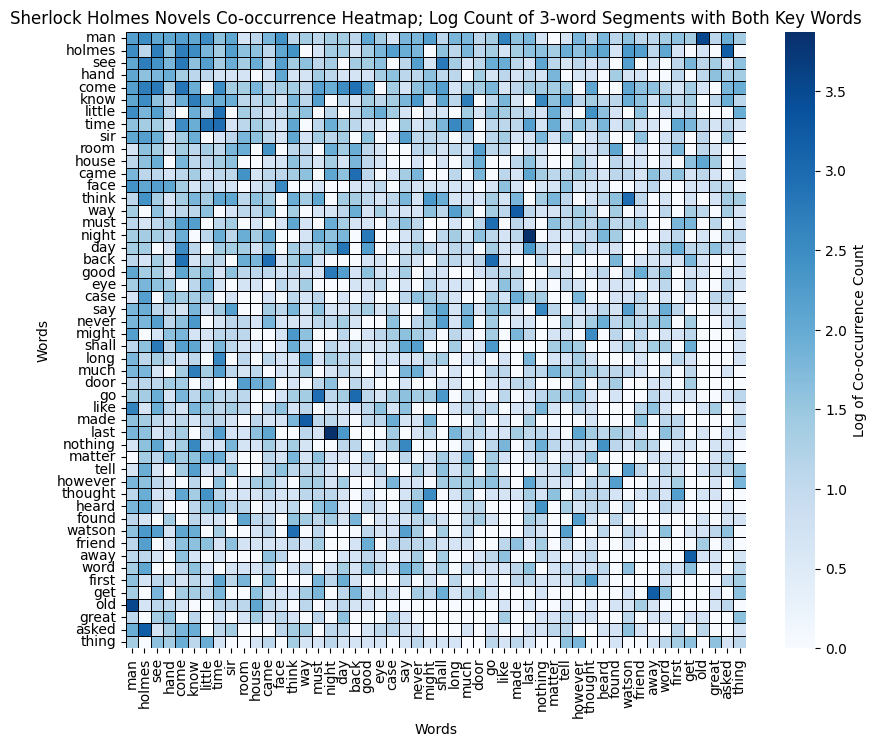

In [9]:
# 50 most common words for all of the novels (without count)
common_word_list = {
    book: [word for word, _ in words]
    for book, words in {
        "Sherlock Holmes Novels": return_most_common(all_text["Sherlock Holmes Novels"], 50),
        }
    .items()
}

# Create a co-occurrence heatmap for the 50 most common words (windowsize 1, which looks at the words next to each common word - 3 word segments)
plot_cooccurrence_heatmap(calculate_word_pair_frequencies(all_text, common_word_list, 1), common_word_list, 1)

This co-occurrence heatmap reveals a lot of common phrases in English that Arthur Conan Doyle uses. Some commons ones: "old man", "get away", "Holmes asked", "last night", "made way", "good night", "little time", "time (to) time". Some words go well with other words, as this analysis shows, as they're the basis of common phrases. Most of these don't offer unique insight into the Sherlock Holmes novels, but some are interesting. "Holmes asked" is so common because Sherlock Holmes is a detective, and it's his job to explore the mystery. "Little time" emphasizes the suspense of the story, which is a plot device used to engage the reader. 

# Most Common Bigrams (N-gram analysis)

An N-gram is similar to a co-occurring word, except it is a n-word phrase that is colocated. For example, "European Union" is a common bigram, and "Covid 19 pandemic" could be a common trigram. In this final section of analysis I will identify and plot the most common bigrams in the Sherlock Holmes novels. 

To begin, I'll use two functions to generate and count n-grams. generate_ngrams takes a text and the length of desired n-grams and user the itertools islice function to return a list of all the n-grams in the text. 

```python
def generate_ngrams(text, n):
    """
    Generate a list of n-grams from a given text.
    Args:
        text (str): Input text.
        n (int): Size of n-grams to generate.
    """
    words = text.split()
    ngrams = list(itertools.islice(zip(*(words[i:] for i in range(n))), len(words) - n + 1))
    return ngrams
```
Next, the analyze_ngrams function uses generate_ngrams and the Counter function to create a dictionary with the title of the book corresponding to a count of all of its n-grams.

```python
def analyze_ngrams(book_texts, n):
    """
    Analyze n-gram frequencies for a collection of books and return as a dict with book titles as keys and n-gram frequencies as values.
    Args:
        book_texts (dict): Dictionary with book titles as keys and full text as values.
        n (int): Size of n-grams to analyze.
    """
    ngram_frequencies = {
        title: Counter(generate_ngrams(text, n))
        for title, text in book_texts.items()
    }
    return ngram_frequencies
```
I finally feed this dictionary into a plot_ngrams function, in which I input what level of n-gram I want to analyze (bigram, trigram, etc.) and how many I would like to graph (10 n-grams per book for example).

```python
def plot_ngrams(ngram_frequencies, top_n, n_gram_length):
    """
    Plot the most frequent n-grams for up to 5 books in subplots.
    Args:
        ngram_frequencies (dict): Dictionary with book titles as keys and n-gram frequency counters as values.
        top_n (int): Number of top n-grams to display.
        n_gram_length (int): length of the n-grams being analyzed.
    """
    # Limit to 5 books for display
    n_books = min(len(ngram_frequencies), 5)
    books_to_plot = list(ngram_frequencies.items())[:n_books]
    fig, axes = plt.subplots(nrows=1, ncols=n_books, figsize=(18, 6), sharey=True)
    if n_books == 1:
        axes = [axes]  # Ensure axes is iterable when only one subplot
    for ax, (title, freq) in zip(axes, books_to_plot):
        # Get top n n-grams and their counts
        most_common = freq.most_common(top_n)
        ngrams, counts = zip(*most_common)
        # Plot data
        bars = ax.bar(range(len(ngrams)), counts, color='blue')
        # Title and axis labels
        ax.set_title(title, fontsize=12)
        ax.set_xticks(range(len(ngrams)))
        ax.set_xticklabels([' '.join(ng) for ng in ngrams], rotation=45, ha="right", fontsize=8)
        ax.set_xlabel("N-Grams", fontsize=10)
        ax.set_ylabel("Count", fontsize=12)
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        # Annotate bars with counts
        for bar, count in zip(bars, counts):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.01,
                str(count),
                ha='center',
                va='bottom',
                fontsize=7
            )
    # Overall title and adjustments
    fig.suptitle(f"Top {top_n} N-Grams of Length {n_gram_length}", fontsize=16)
    fig.tight_layout()
    plt.show()
```
Below I plot the top 10 bigrams in each novel and in all the novels. 

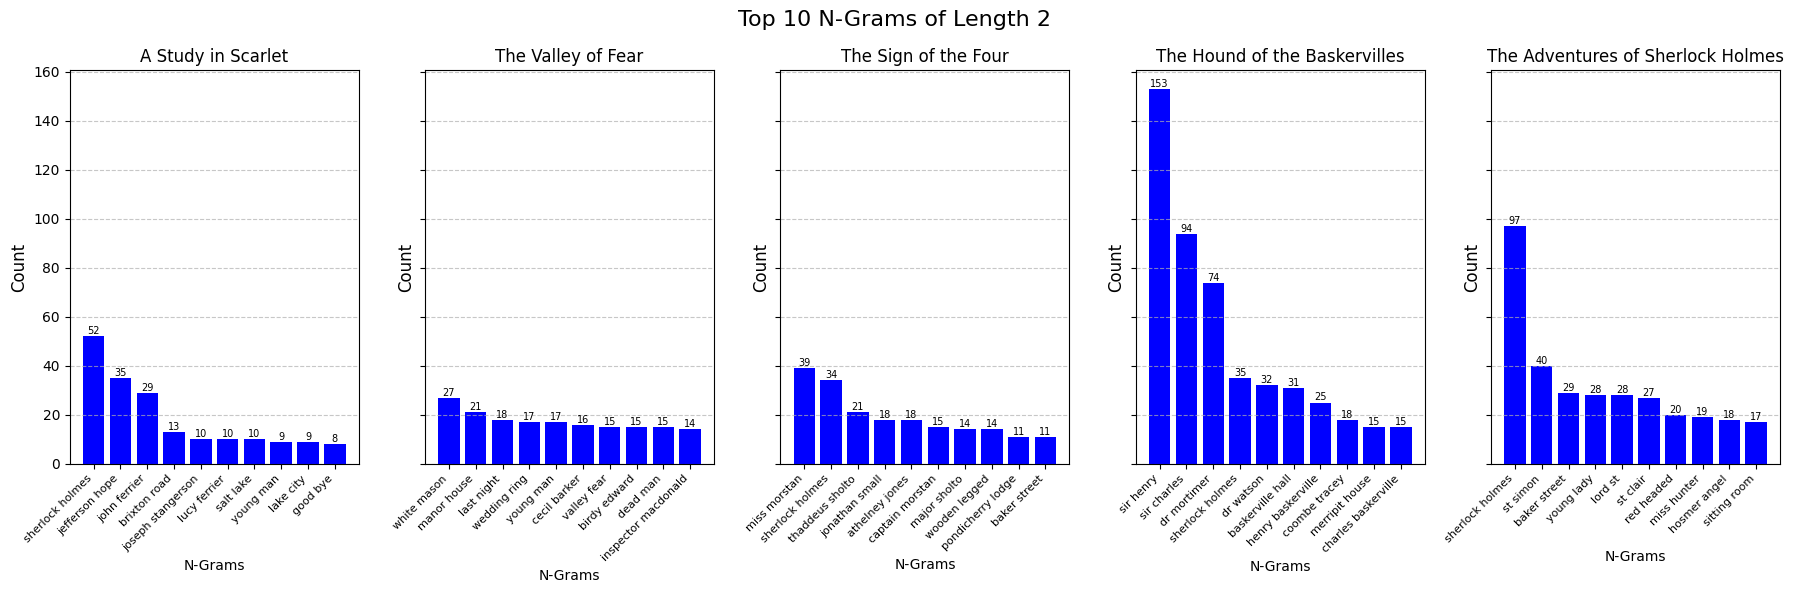

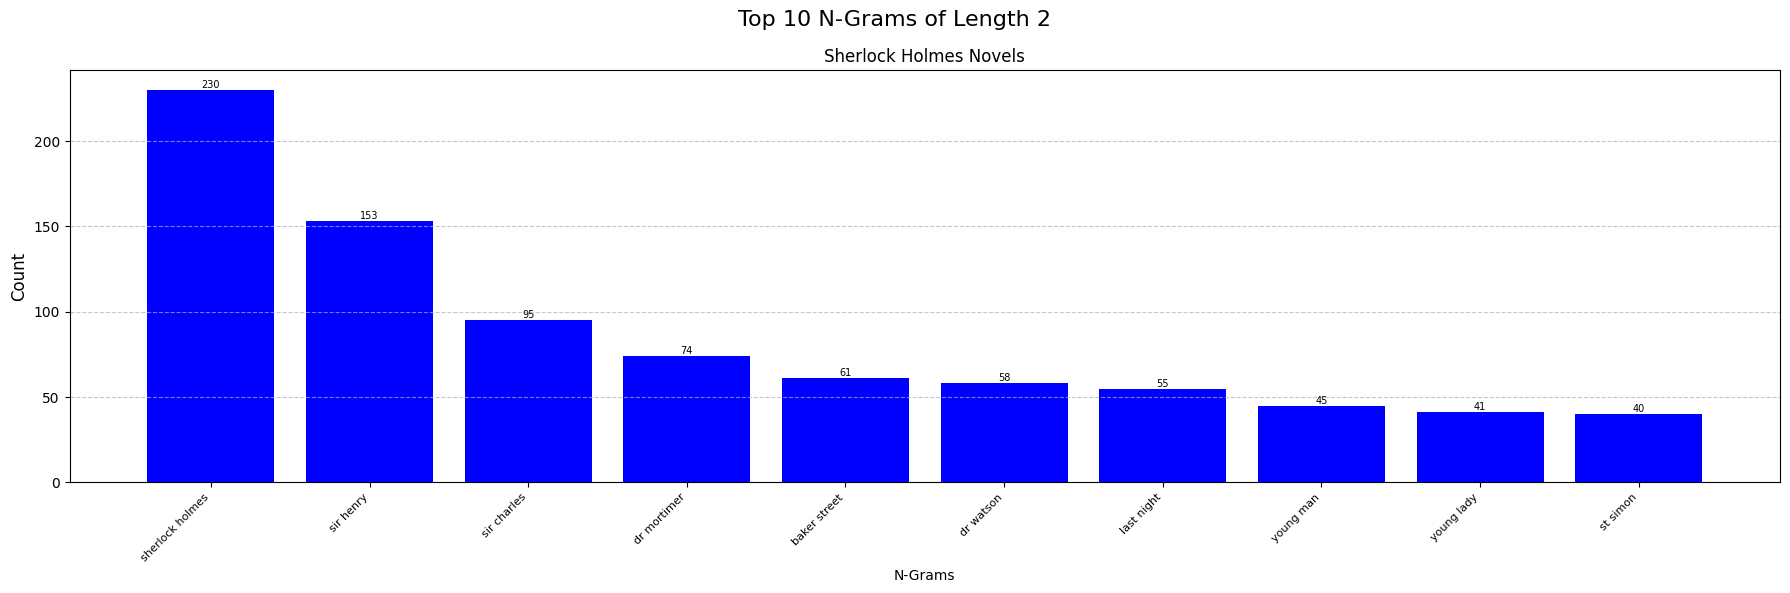

In [10]:
# Plot the top 10 2-word combinations for each book in the collection (itertools)
plot_ngrams(analyze_ngrams(books_text, 2), 10, 2)

# Plot the top 10 2-word combinations for all Sherlock Holmes Novels
plot_ngrams(analyze_ngrams(all_text, 2), 10, 2)

Many of the most common bigrams identified are proper names ("Sherlock Holmes", "Sir Charles", "Sir Henry", "Joseph Strangerson"), places  ("Valley of Fear", "Pondicherry Lodge", "Baker Street"), or common English phrases ("last night", "young man", "young lady"). The most common bigrams, then, appear to represent common ideas in each of the texts. I think compared to individual word analysis, the bigrams offer more insight into what each of the texts is about since it can specify plot elements.

# Technologies Used
NumPy:
Pandas: 
Matplotlib: 
Regular Expressions: 
Iterators/generators (Itertools module)
JSON/CSV: 
URL request:
Seaborn: 
WordCloud: 
NLTK: 

# External Sources
I used this Medium article to learn how to use the WordCloud library and import an image to use as a mask: https://medium.com/@m3redithw/wordclouds-with-python-c287887acc8b. I also used docs.python.org and stackoverflow when I encountered issues with my code or (for example) wanted to look up how to make a heatmap using Seaborn. 

# Assumptions
I only chose to work with the five Sherlock Holmes long novels, but there are also more Sherlock Holmes works which are short stories. These are not included in my analysis.
My code is only compatible with Project Gutenberg texts. I assume that all Project Gutenberg texts specify the title in the way these 5 books do, and they have similar starting and ending segments which instruct when the book begins. If the url specified conforms to these assumptions, my text downloading and processing should work correctly.

# Conclusion
Overall, this analysis of Sherlock Holmes novels met my expectations. I think one of the most interesting insights in my analysis was discovering English phrases in the co-occurrence analysis (like "made way" or "good night"). 


